# Wells Fargo Challenge

- https://www.mindsumo.com/contests/campus-analytics-challenge-2021

### To Complete a Submission:

Build a classification model for predicting elder fraud in the digital payments space as described in Rule 4, which:

- Handles missing variables
- Maximizes the F1 score
- Uses the given data set
- Includes suitable encoding schemes
- Has the least set of feature variables

### Resources
- https://github.com/pdglenn/WellsFargoAnalyticsChallenge

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

data_dir = "./dataset/"

# following few lines are to supress the pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.options.mode.chained_assignment = None 
pd.options.display.max_columns = 20
np.set_printoptions(suppress=True) 

data_dir = "./dataset/"
image_dir = "./images/"


## Loading the data

**Note** `pd.read_excel` gave me an errow while reading the `xlsx` file so had to install `openpyxl` using `pip3 install openpyxl` and give `engine=openpyxl` as an extra arguement.

In [2]:
#!pip3 install openpyxl

In [3]:
# load the file
df_orig = pd.read_excel(data_dir+"trainset.xlsx", engine='openpyxl')
df_orig.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
0,5.38,23619.91,47,4,2777,1/16/2018 11:3:58,cox communications inc.,southwest,nevada,MOBL,...,NV,2/24/2021 15:55:10,1993-01-06,5/3/2021 18:3:58,5/3/2021,SCHPMT,P2P_COMMIT,P2P,5/3/2021,Non-Fraud
1,65.19,0.00,45,5,2721,NaN,charter communications,southwest,california,MOBL,...,CA,NaN,1971-01-07,1/13/2021 19:19:37,1/13/2021,SCHPMT,P2P_COMMIT,P2P,1/13/2021,Non-Fraud


In [4]:
print ("Original data shape:", df_orig.shape)

Original data shape: (14000, 24)


In [5]:
#information of the dataset
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TRAN_AMT                 14000 non-null  float64       
 1   ACCT_PRE_TRAN_AVAIL_BAL  14000 non-null  float64       
 2   CUST_AGE                 14000 non-null  int64         
 3   OPEN_ACCT_CT             14000 non-null  int64         
 4   WF_dvc_age               14000 non-null  int64         
 5   PWD_UPDT_TS              10875 non-null  object        
 6   CARR_NAME                11291 non-null  object        
 7   RGN_NAME                 11291 non-null  object        
 8   STATE_PRVNC_TXT          11291 non-null  object        
 9   ALERT_TRGR_CD            14000 non-null  object        
 10  DVC_TYPE_TXT             12239 non-null  object        
 11  AUTHC_PRIM_TYPE_CD       14000 non-null  object        
 12  AUTHC_SCNDRY_STAT_TXT    13926 n

In [6]:
# check the target classes
df_orig["FRAUD_NONFRAUD"].unique()

array(['Non-Fraud', 'Fraud'], dtype=object)

## Train test split

Before doing any data visualization let's set some test data aside and use them to score the model later on.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# stratify the target column so that the distribution look similar in the train and test data
df_train0, df_test0 = train_test_split(df_orig,
                               test_size = .2,
                               random_state = 8848,
                               shuffle = True,
                               stratify = df_orig["FRAUD_NONFRAUD"])

In [8]:
df = df_train0.copy()

In [9]:
df.head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,PWD_UPDT_TS,CARR_NAME,RGN_NAME,STATE_PRVNC_TXT,ALERT_TRGR_CD,...,CUST_STATE,PH_NUM_UPDT_TS,CUST_SINCE_DT,TRAN_TS,TRAN_DT,ACTN_CD,ACTN_INTNL_TXT,TRAN_TYPE_CD,ACTVY_DT,FRAUD_NONFRAUD
2413,487.93,3714.91,43,5,1037,NaN,NaN,NaN,NaN,MOBL,...,CO,5/0/2020 12:33:41,1988-01-11,4/13/2021 5:2:29,4/13/2021,SCHPMT,P2P_COMMIT,P2P,4/13/2021,Fraud
1003,4.84,0.00,53,5,305,4/12/2017 15:54:53,NaN,NaN,NaN,MOBL,...,TX,NaN,1987-04-05,4/29/2021 22:54:53,4/29/2021,SCHPMT,P2P_COMMIT,P2P,4/29/2021,Non-Fraud


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11200 entries, 2413 to 114
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   TRAN_AMT                 11200 non-null  float64       
 1   ACCT_PRE_TRAN_AVAIL_BAL  11200 non-null  float64       
 2   CUST_AGE                 11200 non-null  int64         
 3   OPEN_ACCT_CT             11200 non-null  int64         
 4   WF_dvc_age               11200 non-null  int64         
 5   PWD_UPDT_TS              8684 non-null   object        
 6   CARR_NAME                9022 non-null   object        
 7   RGN_NAME                 9022 non-null   object        
 8   STATE_PRVNC_TXT          9022 non-null   object        
 9   ALERT_TRGR_CD            11200 non-null  object        
 10  DVC_TYPE_TXT             9805 non-null   object        
 11  AUTHC_PRIM_TYPE_CD       11200 non-null  object        
 12  AUTHC_SCNDRY_STAT_TXT    11140 

In [11]:
df.shape

(11200, 24)

In [12]:
# find numerical and categorical columns
nume_cols = list(df.select_dtypes(include="number").columns)
cate_cols = list(df.select_dtypes(exclude="number").columns)
cate_cols.remove('FRAUD_NONFRAUD')

In [13]:
print ("Numeric Columns:\n", nume_cols)
print ("")
print ("Categorical Columns:\n", cate_cols)

Numeric Columns:
 ['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'CUST_AGE', 'OPEN_ACCT_CT', 'WF_dvc_age', 'CUST_ZIP']

Categorical Columns:
 ['PWD_UPDT_TS', 'CARR_NAME', 'RGN_NAME', 'STATE_PRVNC_TXT', 'ALERT_TRGR_CD', 'DVC_TYPE_TXT', 'AUTHC_PRIM_TYPE_CD', 'AUTHC_SCNDRY_STAT_TXT', 'CUST_STATE', 'PH_NUM_UPDT_TS', 'CUST_SINCE_DT', 'TRAN_TS', 'TRAN_DT', 'ACTN_CD', 'ACTN_INTNL_TXT', 'TRAN_TYPE_CD', 'ACTVY_DT']


In [14]:
df[nume_cols].head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age,CUST_ZIP
2413,487.93,3714.91,43,5,1037,80234
1003,4.84,0.00,53,5,305,75232


In [15]:
nume_cols.remove('CUST_ZIP')
cate_cols.append('CUST_ZIP')

In [16]:
print ("Numeric Columns:\n", nume_cols)
print ("")
print ("Categorical Columns:\n", cate_cols)

Numeric Columns:
 ['TRAN_AMT', 'ACCT_PRE_TRAN_AVAIL_BAL', 'CUST_AGE', 'OPEN_ACCT_CT', 'WF_dvc_age']

Categorical Columns:
 ['PWD_UPDT_TS', 'CARR_NAME', 'RGN_NAME', 'STATE_PRVNC_TXT', 'ALERT_TRGR_CD', 'DVC_TYPE_TXT', 'AUTHC_PRIM_TYPE_CD', 'AUTHC_SCNDRY_STAT_TXT', 'CUST_STATE', 'PH_NUM_UPDT_TS', 'CUST_SINCE_DT', 'TRAN_TS', 'TRAN_DT', 'ACTN_CD', 'ACTN_INTNL_TXT', 'TRAN_TYPE_CD', 'ACTVY_DT', 'CUST_ZIP']


In [17]:
df[nume_cols].head(5)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age
2413,487.93,3714.91,43,5,1037
1003,4.84,0.00,53,5,305
8660,494.94,2525.50,70,9,583
6349,0.01,0.00,70,6,467
1860,488.36,4344.55,38,4,0


In [18]:
impute_vals={}

for col in df.columns:
    if col in nume_cols:
        impute_vals[col] = df[col].median()
    elif col in cate_cols:
        impute_vals[col] = df[col].mode()[0]
        
impute_vals

{'TRAN_AMT': 162.07,
 'ACCT_PRE_TRAN_AVAIL_BAL': 2396.1549999999997,
 'CUST_AGE': 59.0,
 'OPEN_ACCT_CT': 5.0,
 'WF_dvc_age': 366.5,
 'PWD_UPDT_TS': '5/18/2020 4:7:20',
 'CARR_NAME': 'cox communications inc.',
 'RGN_NAME': 'southwest',
 'STATE_PRVNC_TXT': 'california',
 'ALERT_TRGR_CD': 'MOBL',
 'DVC_TYPE_TXT': 'MOBILE',
 'AUTHC_PRIM_TYPE_CD': 'UN_PWD',
 'AUTHC_SCNDRY_STAT_TXT': 'ALLOW',
 'CUST_ZIP': 77459,
 'CUST_STATE': 'CA',
 'PH_NUM_UPDT_TS': '7/8/2019 6:45:37',
 'CUST_SINCE_DT': Timestamp('1997-08-01 00:00:00'),
 'TRAN_TS': '2/3/2021 9:0:51',
 'TRAN_DT': '2/28/2021',
 'ACTN_CD': 'SCHPMT',
 'ACTN_INTNL_TXT': 'P2P_COMMIT',
 'TRAN_TYPE_CD': 'P2P',
 'ACTVY_DT': '2/28/2021'}

In [19]:
cols_to_drop = ['PH_NUM_UPDT_TS', 'PWD_UPDT_TS', 'CARR_NAME', 'RGN_NAME', 'STATE_PRVNC_TXT']
nume_cols    = [c for c in nume_cols if c not in cols_to_drop]
cate_cols    = [c for c in cate_cols if c not in cols_to_drop]

In [20]:
def impute_data(df, impute_dict=impute_vals):
    """
    this function takes in a dataframe and list of columns which have missing values
    then imputes those columns using the precomputed values.
    """
    for col in list(impute_dict.keys()):
        df[col] = df[col].fillna(impute_dict[col])
    return df

In [21]:
# impute the columns : cols_to_impute
df=impute_data(df)

In [22]:
df.isnull().sum()

TRAN_AMT                   0
ACCT_PRE_TRAN_AVAIL_BAL    0
CUST_AGE                   0
OPEN_ACCT_CT               0
WF_dvc_age                 0
PWD_UPDT_TS                0
CARR_NAME                  0
RGN_NAME                   0
STATE_PRVNC_TXT            0
ALERT_TRGR_CD              0
DVC_TYPE_TXT               0
AUTHC_PRIM_TYPE_CD         0
AUTHC_SCNDRY_STAT_TXT      0
CUST_ZIP                   0
CUST_STATE                 0
PH_NUM_UPDT_TS             0
CUST_SINCE_DT              0
TRAN_TS                    0
TRAN_DT                    0
ACTN_CD                    0
ACTN_INTNL_TXT             0
TRAN_TYPE_CD               0
ACTVY_DT                   0
FRAUD_NONFRAUD             0
dtype: int64

In [23]:
df[nume_cols].head(2)

,TRAN_AMT,ACCT_PRE_TRAN_AVAIL_BAL,CUST_AGE,OPEN_ACCT_CT,WF_dvc_age
2413,487.93,3714.91,43,5,1037
1003,4.84,0.00,53,5,305


## Feature Transformation

- Convert the categorical featurs into small number of categories when possible

In [24]:
def wrangle_column_data(df):
    #CUST_STATE
    # keep only CO, TX, MN, AZ and convert rest into OTHER
    df["CUST_STATE"] = df["CUST_STATE"].apply(lambda x: x if x in ["CO", "TX", "MN", "AZ"] else "OTHER")
    #OPEN_ACCT_CT
    #keep only the [2,9] and convert others to 10
    df["OPEN_ACCT_CT"] = df["OPEN_ACCT_CT"].apply(lambda x: x if x in range(1,13) else 13)
    return df

In [25]:
df=wrangle_column_data(df)

In [26]:
nume_cols

['TRAN_AMT',
 'ACCT_PRE_TRAN_AVAIL_BAL',
 'CUST_AGE',
 'OPEN_ACCT_CT',
 'WF_dvc_age']

In [27]:
cate_cols_to_keep = ['ALERT_TRGR_CD', "CUST_STATE"]

In [28]:
df[cate_cols_to_keep].head()

,ALERT_TRGR_CD,CUST_STATE
2413,MOBL,CO
1003,MOBL,TX
8660,MOBL,TX
6349,ONLN,MN
1860,MOBL,AZ


## Build a model with only Numerical features

In [29]:
# map Fraud to 1 and Non-Fraud to 0 in the dataframe for both train and test data
df["FRAUD_NONFRAUD"] = df["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})

In [30]:
X_train1, y_train1 = df[nume_cols], df["FRAUD_NONFRAUD"]

In [31]:
# prepare test data
df_test = df_test0.copy()
print ("missing values in test data:\n", df_test[nume_cols].isnull().sum() )
df_test["FRAUD_NONFRAUD"] = df_test["FRAUD_NONFRAUD"].map({"Fraud":1,"Non-Fraud":0})
X_test1,  y_test1  = df_test[nume_cols], df_test["FRAUD_NONFRAUD"]

missing values in test data:
 TRAN_AMT                   0
ACCT_PRE_TRAN_AVAIL_BAL    0
CUST_AGE                   0
OPEN_ACCT_CT               0
WF_dvc_age                 0
dtype: int64


In [32]:
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((11200, 5), (11200,), (2800, 5), (2800,))

### Base Model: Logistic Regression, Random Forest, XGBoost

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve

In [34]:
class Model_training:
    def __init__(self, model, X_train, y_train, X_test, y_test, savename="Fig"):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test  = X_test
        self.y_test  = y_test
        self.savename = savename
        
        self.model.fit(self.X_train, self.y_train)
    
    def print_metrics(self):
        round_to_pct = lambda x: np.round(100*x, 2)
        y_pred = self.model.predict(self.X_test)
        ac = round_to_pct(accuracy_score(self.y_test, y_pred))
        f1 = round_to_pct(f1_score(self.y_test, y_pred))
        pr = round_to_pct(precision_score(self.y_test, y_pred))
        re = round_to_pct(recall_score(self.y_test, y_pred))
        print (f"Accuracy = {ac}% F1 Score= {f1}% \nPrecision={pr}% Recall= {re}%")
        print (classification_report(self.y_test, y_pred))
        return (self.model, (ac, f1, pr, re))
        
    def displot(self):
        pr=self.model.predict_proba(self.X_test)        
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)

        pr_df = pd.DataFrame({'pred_0':pr[:,0], 
                              'pred_1':pr[:,1], 
                              'y': self.y_test})

        ax=sns.displot(data=pr_df, 
                       x='pred_1', 
                       hue='y', 
                       alpha=0.8, 
                       kind="kde",
                       height = 3.5, 
                       aspect=1.8);
        
        plt.xlabel("Prob. Positive Predictions", fontsize=16)
        plt.text(0.2, 2, "ROC_AUC="+str(roc_auc), fontsize=16)
        plt.ylabel("Density", fontsize=16)
        
        plt.yticks(fontsize=16);
        plt.xticks(fontsize=16);
        figname = "images/displot_"+self.savename+"_nb1.png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

    def feature_importance(self):

        df_imp = pd.DataFrame({"Feature":self.X_train.columns, 
                               "Feature Importance":self.model.feature_importances_})
        
        df_imp = df_imp.sort_values(by=['Feature Importance'],
                                    axis=0,
                                    ascending=True)
        
        df_imp.plot(kind='barh',
                    x='Feature', 
                    y='Feature Importance',
                    color="C2", figsize=(8,5));
        
        plt.grid(axis='x')
        plt.yticks(fontsize=16);
        plt.ylabel('');
        plt.xticks(fontsize=16);
        plt.legend(loc='best',fontsize=16);
        
        figname = "images/feat_imp_"+self.savename+"_nb1.png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')
        
    def plot_roc_curve(self):
        roc_auc = np.round(roc_auc_score(self.y_test,
                                         self.model.predict_proba(self.X_test)[:, 1]), 2)
        label_name = self.savename +"\n AUC = "+str(roc_auc)
        
        plot_roc_curve(self.model, self.X_test, self.y_test,
                       lw=3., color='C2', label=label_name)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xticks(fontsize=16);
        plt.yticks(fontsize=16);
        plt.legend(loc="center", fontsize=14);
        plt.axvline(x=0, color='k', ls='--', lw=1)
        plt.axhline(y=0, color='k', ls='--', lw=1)
        plt.axhline(y=1, color='k', ls='--', lw=1)
        
        figname = "images/roc_curve_"+self.savename+"_nb1.png"
        plt.savefig(figname, dpi=300, bbox_inches='tight')

Accuracy = 93.64% F1 Score= 88.81% 
Precision=93.26% Recall= 84.75%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1967
           1       0.93      0.85      0.89       833

    accuracy                           0.94      2800
   macro avg       0.94      0.91      0.92      2800
weighted avg       0.94      0.94      0.94      2800



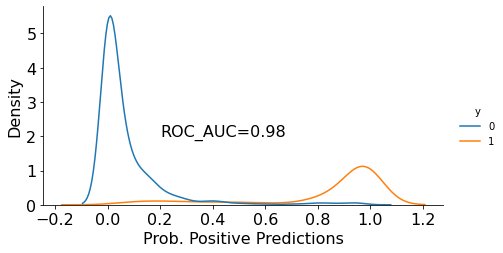

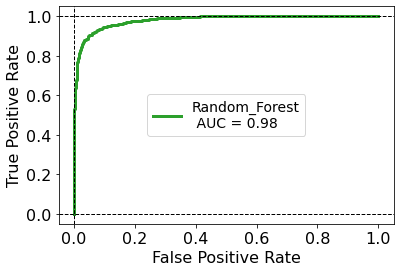

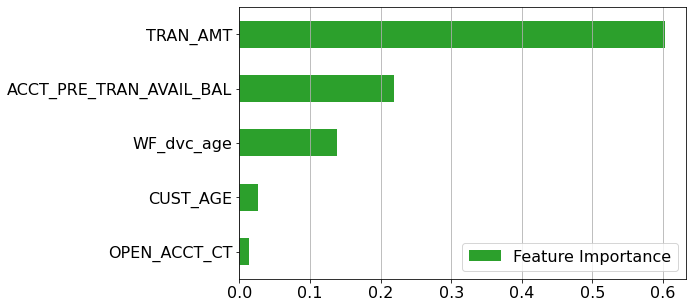

In [35]:
model_rf = RandomForestClassifier(max_depth=10,
                                  random_state=8848)

mod = Model_training(model_rf, 
                     X_train1, y_train1,
                     X_test1, y_test1,
                     "Random_Forest")
mod_tr, _= mod.print_metrics()
mod.displot()
mod.plot_roc_curve()
mod.feature_importance()

For a base model: F1 score  ~ 88% is a great result.

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   32.0s finished


Accuracy = 93.57% F1 Score= 88.78% 
Precision=92.35% Recall= 85.47%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.92      0.85      0.89       833

    accuracy                           0.94      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.94      0.94      0.93      2800



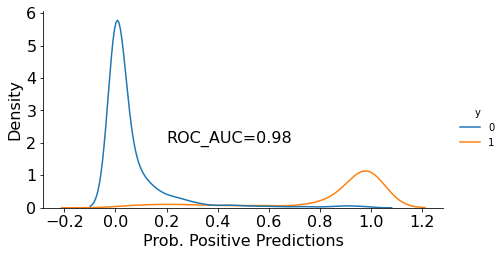

In [36]:
model_rf_gs = GridSearchCV(RandomForestClassifier(),
                           param_grid={'max_depth':[8, 9, 10, 11, 12, 14]},
                           scoring ='f1',
                           verbose=1)

mod2 = Model_training(model_rf_gs,
                      X_train1, y_train1, X_test1, y_test1,
                      "random_forest_grid_search")
mod_tr, _= mod2.print_metrics()
mod2.displot()

In [37]:
mod_tr.best_params_

{'max_depth': 14}

Accuracy = 70.86% F1 Score= 23.02% 
Precision=53.74% Recall= 14.65%
              precision    recall  f1-score   support

           0       0.72      0.95      0.82      1967
           1       0.54      0.15      0.23       833

    accuracy                           0.71      2800
   macro avg       0.63      0.55      0.53      2800
weighted avg       0.67      0.71      0.64      2800



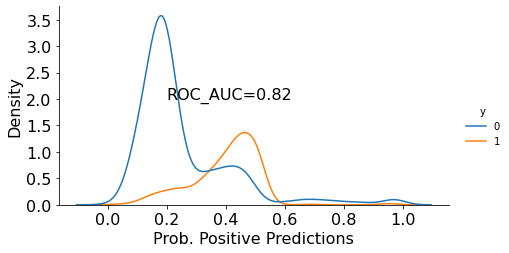

In [38]:
model_lr = LogisticRegression(max_iter=5000)
mod3 = Model_training(model_lr, X_train1, y_train1, X_test1, y_test1, "logistic_regression")
mod_tr, _= mod3.print_metrics()
mod3.displot()

Accuracy = 93.14% F1 Score= 88.13% 
Precision=90.83% Recall= 85.59%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.91      0.86      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800



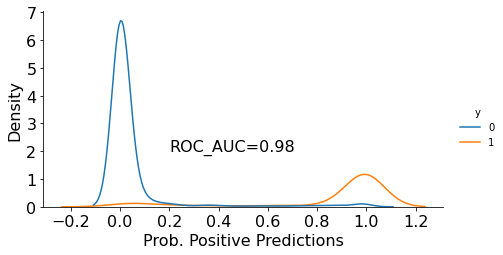

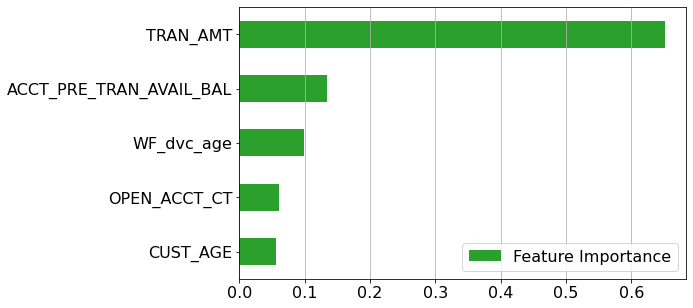

In [39]:
xgb = XGBClassifier(verbosity=1,
                    use_label_encoder=False, 
                    max_depth=10, 
                    eval_metric = "logloss")

mod4 = Model_training(xgb, X_train1, y_train1, X_test1, y_test1, "xgb")
mod_tr, _= mod4.print_metrics()
mod4.displot()
mod4.feature_importance()

Accuracy = 92.93% F1 Score= 87.78% 
Precision=90.34% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.90      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.91      2800
weighted avg       0.93      0.93      0.93      2800



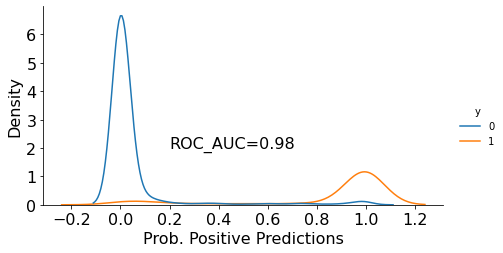

In [40]:
xgb_gs = GridSearchCV(XGBClassifier(),
                      param_grid={'max_depth':[8, 9, 10, 11, 12, 14],
                                  'eval_metric' :["logloss"],
                                  'reg_alpha':[0.1, 0.5]},
                      scoring = 'f1',
                      verbose = 0 )

mod5 = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1, "xgb_grid_search")
mod_tr, _= mod5.print_metrics()
mod5.displot()

In [41]:
mod_tr.best_params_

{'eval_metric': 'logloss', 'max_depth': 11, 'reg_alpha': 0.1}

## Deep learning models

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras import backend as K

In [43]:
# this piece of code copied from 
#https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [44]:
def make_model_dense(X_train, y_train):
    model = Sequential()
    model.add(Dense(1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu'))
    opt = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=custom_f1)
    return model

In [45]:
model_dnn = make_model_dense(X_train1, y_train1)
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 6         
_________________________________________________________________
dropout (Dropout)            (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [46]:
history_dnn = model_dnn.fit(X_train1, y_train1,
                            validation_data=(X_test1, y_test1),
                            epochs=20,
                            batch_size=32,
                            verbose=0)

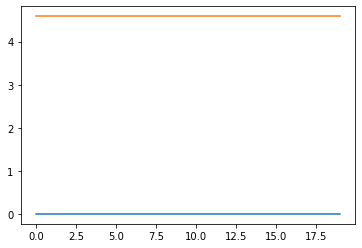

In [47]:
plt.plot(history_dnn.history['val_custom_f1'])
plt.plot(history_dnn.history['val_loss'])

## Modeling including categorical features

In [48]:
import category_encoders as ce

In [49]:
df2 = df_train0.copy()
df2["FRAUD_NONFRAUD"] =  df2["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2 = impute_data(df2)
df2 = wrangle_column_data(df2)

In [50]:
encoder = ce.OneHotEncoder()
df2_tr_cat = encoder.fit_transform(df[cate_cols_to_keep])
df2_tr_join = pd.concat( [df2[nume_cols], df2_tr_cat], axis=1)
X_train2 = df2_tr_join.values
y_train2 = df2["FRAUD_NONFRAUD"].values

In [51]:
# test data

df2_te = df_test0.copy()
df2_te["FRAUD_NONFRAUD"] = df2_te["FRAUD_NONFRAUD"].map({"Fraud":1, "Non-Fraud":0})
df2_te = impute_data(df2_te)
df2_te = wrangle_column_data(df2_te)

In [52]:
df2_te_cat = encoder.transform(df2_te[cate_cols_to_keep])
df2_te_join = pd.concat( [df2_te[nume_cols], df2_te_cat], axis=1)
X_test2 = df2_te_join.values
y_test2 = df2_te["FRAUD_NONFRAUD"].values

In [53]:
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((11200, 12), (11200,), (2800, 12), (2800,))

Accuracy = 92.93% F1 Score= 87.78% 
Precision=90.34% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.90      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.91      2800
weighted avg       0.93      0.93      0.93      2800



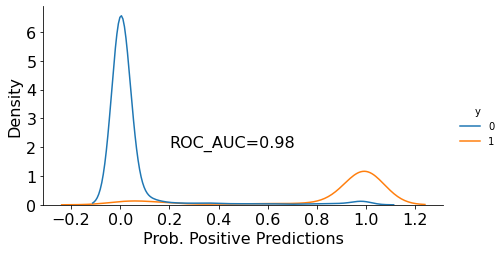

In [54]:
xgb = XGBClassifier(verbosity=1,
                    max_depth=10,
                    eval_metric = "logloss")

mod6 = Model_training(xgb, X_train2, y_train2, X_test2, y_test2)
mod_trained, _ = mod5.print_metrics()
mod6.displot()

In [55]:
from sklearn.svm import SVC

Accuracy = 92.93% F1 Score= 87.78% 
Precision=90.34% Recall= 85.35%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1967
           1       0.90      0.85      0.88       833

    accuracy                           0.93      2800
   macro avg       0.92      0.91      0.91      2800
weighted avg       0.93      0.93      0.93      2800



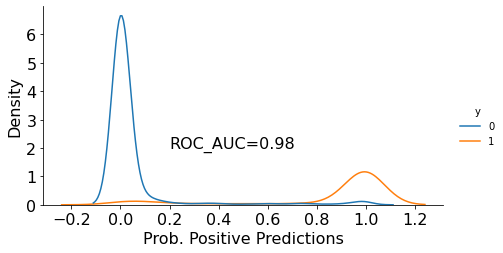

In [56]:
svm = SVC(gamma='auto')
mod = Model_training(xgb_gs, X_train1, y_train1, X_test1, y_test1)
mod_tr, _= mod.print_metrics()
mod.displot()

In [57]:
def train_svm_gs():
    svm_gs = GridSearchCV(SVC(),
                          param_grid={'C':[0.1, 0.5, 1.0],
                                      'kernel':['poly', 'rbf'],
                                      'gamma': ['scale', 'auto']},
                          scoring = 'f1',
                          verbose = 1 )
    
    mod = Model_training(svm_gs, X_train1, y_train1, X_test1, y_test1)
    mod_tr, _= mod.print_metrics()
    mod.displot()
    
#this takes a little long time so think before running
#train_svm_gs()

## Voting Classifier

In [58]:
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(max_depth=10,
                              random_state=8848)

clf3 = XGBClassifier(verbosity=1,
                    max_depth=13,
                    eval_metric = "logloss")

clf_voting = VotingClassifier(
    estimators=[('rf', clf2), ('xgb', clf3)],
    voting='soft')

Accuracy = 93.46% F1 Score= 88.58% 
Precision=92.21% Recall= 85.23%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1967
           1       0.92      0.85      0.89       833

    accuracy                           0.93      2800
   macro avg       0.93      0.91      0.92      2800
weighted avg       0.93      0.93      0.93      2800



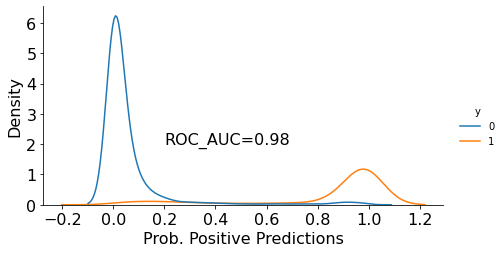

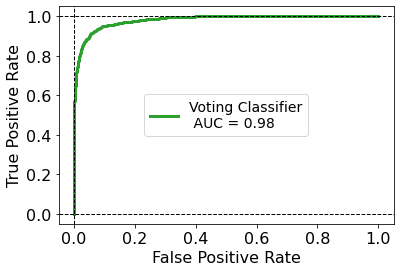

In [59]:
mod8 = Model_training(clf_voting, X_train1, y_train1, X_test1, y_test1, "Voting Classifier")
mod_tr, _= mod8.print_metrics()
mod8.displot()
mod8.plot_roc_curve()
#mod8.feature_importance()